In [1]:
import warnings
warnings.filterwarnings('ignore')

#### Reading News Data

In [2]:
import pandas as pd
import wordninja

NEWS_DATA_HEADERS = ["News ID", "Category", "SubCategory", "Title", "Abstract", "URL", "Title Entities", "Abstract Entities"]
SPLIT_WORDS = lambda text: ' '.join(wordninja.split(text))

news_data_train = pd.read_csv('../data/MINDsmall_train/news.tsv', delimiter='\t', names=NEWS_DATA_HEADERS,
    usecols=lambda col: col not in ['URL', 'Title Entities', 'Abstract Entities'])

news_data_train['SubCategory'] = news_data_train['SubCategory'].map(SPLIT_WORDS)
news_data_train['Category'] = news_data_train['Category'].map(SPLIT_WORDS)
news_data_train['Abstract'] = news_data_train['Abstract'].fillna("")

news_data_train['News Description'] = news_data_train['Title'].str.cat(news_data_train['Abstract'], sep=' ').str.strip()
news_data_train = news_data_train.drop(columns=['Title', 'Abstract'])

news_data_train.head()

,News ID,Category,SubCategory,News Description
0,N55528,lifestyle,lifestyle royals,"The Brands Queen Elizabeth, Prince Charles, an..."
1,N19639,health,weight loss,50 Worst Habits For Belly Fat These seemingly ...
2,N61837,news,news world,The Cost of Trump's Aid Freeze in the Trenches...
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De..."


In [3]:
news_data_train.shape

(51282, 4)

#### Reading User Behaviour Data

In [4]:
BEHAVIOUR_DATA_HEADERS = ["Impression ID", "User ID", "Time", "History", "Impressions"]

user_behaviour_data_train = pd.read_csv('../data/MINDsmall_train/behaviors.tsv', delimiter='\t', names=BEHAVIOUR_DATA_HEADERS)
user_behaviour_data_train.head()

,Impression ID,User ID,Time,History,Impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [5]:
user_behaviour_data_train.shape

(156965, 5)

#### Creating Nodes Data for the Graph

In [6]:
# Process News Data
nodes_data_train = (
    news_data_train[['News ID', 'News Description']]
    .drop_duplicates()
    .rename(columns={'News ID': 'node_label', 'News Description': 'node_feature'})
)
nodes_data_train['node_type'] = 'news_ids'

unique_categories = news_data_train['Category'].unique()
unique_subcategories = news_data_train['SubCategory'].unique()

category_data = pd.DataFrame({'node_label': unique_categories, 'node_feature': unique_categories, 'node_type': 'news_category'})
sub_category_data = pd.DataFrame({'node_label': unique_subcategories, 'node_feature': unique_subcategories, 'node_type': 'news_sub_category'})

nodes_data_train = pd.concat([nodes_data_train, category_data, sub_category_data], ignore_index=True)

# Process user data
user_data = user_behaviour_data_train[['User ID', 'History']].drop_duplicates()
user_data['History'] = user_data['History'].str.split(' ')

user_data = (user_data.explode('History').dropna(subset=['History']).drop_duplicates().groupby('User ID')['History'].agg(list)
             .reset_index()
             .rename(columns={'User ID': 'node_label', 'History': 'node_feature'}))

user_data['node_type'] = 'user_ids'

nodes_data_train = pd.concat([nodes_data_train, user_data], ignore_index=True)

# Process Cold Start Users
user_data = user_behaviour_data_train[['User ID', 'History']].drop_duplicates()
user_data['History'] = user_data['History'].str.split(' ')

avg_news_per_user = user_data['History'].dropna().apply(len).sum() // user_data['History'].count()
popular_news_labels = user_data['History'].explode().value_counts().index[:avg_news_per_user].tolist()

cold_start_users = user_data[user_data['History'].isna()][["User ID"]].reset_index(drop=True)
cold_start_users['History'] = [popular_news_labels] * cold_start_users.shape[0]
cold_start_users['node_type'] = 'user_ids'

cold_start_users = cold_start_users.rename(columns={'User ID': 'node_label', 'History': 'node_feature'})

nodes_data_train = pd.concat([nodes_data_train, cold_start_users], ignore_index=True)

# Final Nodes Data
nodes_data_train = nodes_data_train.reset_index(drop=True).reset_index().rename(columns={'index': 'node_id'})
nodes_data_train.head()

,node_id,node_label,node_feature,node_type
0,0,N55528,"The Brands Queen Elizabeth, Prince Charles, an...",news_ids
1,1,N19639,50 Worst Habits For Belly Fat These seemingly ...,news_ids
2,2,N61837,The Cost of Trump's Aid Freeze in the Trenches...,news_ids
3,3,N53526,I Was An NBA Wife. Here's How It Affected My M...,news_ids
4,4,N38324,"How to Get Rid of Skin Tags, According to a De...",news_ids


In [7]:
nodes_data_train.shape

(101561, 4)

In [8]:
import numpy as np
import torch
from sentence_transformers import SentenceTransformer

np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)


def generate_news_embeddings(news_data: pd.DataFrame, embedding_model: SentenceTransformer) -> torch.Tensor:
    return embedding_model.encode(news_data['node_feature'].values.tolist(), convert_to_tensor=True, show_progress_bar=True, device=device)

def generate_user_embeddings(user_data: pd.DataFrame, news_data: pd.DataFrame) -> torch.Tensor:
    user_data = user_data.explode('node_feature')
    merged_data = news_data.set_index('node_label')['feature_embedding']
    user_data['feature_embedding'] = user_data['node_feature'].map(merged_data)

    user_data = user_data.dropna(subset=['feature_embedding'])

    user_embeddings = (
        user_data.groupby(['node_id', 'node_label', 'node_type'])['feature_embedding']
        .apply(lambda x: torch.tensor(np.stack(x.values).mean(axis=0)))
    )

    return torch.stack(user_embeddings.tolist()).to(device)

In [9]:
news_feat_embeddings = generate_news_embeddings(news_data=nodes_data_train[nodes_data_train['node_type'] != 'user_ids'], embedding_model=embedding_model)

news_mask = nodes_data_train[nodes_data_train['node_type'] != 'user_ids'].copy()
news_mask['feature_embedding'] = news_feat_embeddings.to('cpu').tolist()

news_mask = news_mask.loc[news_mask['node_type'] == 'news_ids', ['node_label', 'feature_embedding']]

user_feat_embeddings = generate_user_embeddings(
    user_data=nodes_data_train[nodes_data_train['node_type'] == 'user_ids'], news_data=news_mask)

news_feat_embeddings.shape, user_feat_embeddings.shape

Batches:   0%|          | 0/1612 [00:00<?, ?it/s]

(torch.Size([51561, 384]), torch.Size([50000, 384]))

In [10]:
(nodes_data_train.shape,
 nodes_data_train[nodes_data_train['node_type'] != 'user_ids'].shape,
 nodes_data_train[nodes_data_train['node_type'] == 'user_ids'].shape)

((101561, 4), (51561, 4), (50000, 4))

In [11]:
feature_embeddings = torch.concat((news_feat_embeddings, user_feat_embeddings), dim=0)

In [12]:
nodes_data_train

,node_id,node_label,node_feature,node_type
0,0,N55528,"The Brands Queen Elizabeth, Prince Charles, an...",news_ids
1,1,N19639,50 Worst Habits For Belly Fat These seemingly ...,news_ids
2,2,N61837,The Cost of Trump's Aid Freeze in the Trenches...,news_ids
3,3,N53526,I Was An NBA Wife. Here's How It Affected My M...,news_ids
4,4,N38324,"How to Get Rid of Skin Tags, According to a De...",news_ids
...,...,...,...,...
101556,101556,U56010,"[N306, N42620, N45794, N31801, N55189, N43142,...",user_ids
101557,101557,U60279,"[N306, N42620, N45794, N31801, N55189, N43142,...",user_ids
101558,101558,U57450,"[N306, N42620, N45794, N31801, N55189, N43142,...",user_ids
101559,101559,U13835,"[N306, N42620, N45794, N31801, N55189, N43142,...",user_ids


In [13]:
from tqdm import tqdm

graph_nodes = [
    (idx, dict(
        node_label=row['node_label'],
        node_type=row['node_type'],
        feature_embeddings=feature_embeddings[idx]
    ))
    for idx, row in tqdm(nodes_data_train.iterrows(), total=nodes_data_train.shape[0], desc="Creating Graph Node Structure List")
]

len(graph_nodes)

Creating Graph Node Structure List: 100%|██████████| 101561/101561 [00:02<00:00, 40204.88it/s]


101561

#### Creating Edges Data for Graph

In [14]:
edges_data = pd.DataFrame()

category_mapping = nodes_data_train[nodes_data_train['node_type'] == 'news_category'].set_index('node_label')['node_id'].to_dict()
sub_category_mapping = nodes_data_train[nodes_data_train['node_type'] == 'news_sub_category'].set_index('node_label')['node_id'].to_dict()

category_data = news_data_train[['Category', 'SubCategory']].drop_duplicates()
category_data['Category'] = category_data['Category'].map(category_mapping)
category_data['SubCategory'] = category_data['SubCategory'].map(sub_category_mapping)
edges_data = category_data.rename(columns={'Category': 'source', 'SubCategory': 'destination'})

news_id_mapping = nodes_data_train[nodes_data_train['node_type'] == 'news_ids'].set_index('node_label')['node_id'].to_dict()

sub_category_data = news_data_train[['SubCategory', 'News ID']].drop_duplicates()
sub_category_data['SubCategory'] = sub_category_data['SubCategory'].map(sub_category_mapping)
sub_category_data['News ID'] = sub_category_data['News ID'].map(news_id_mapping)
sub_category_data = sub_category_data.rename(columns={'SubCategory': 'source', 'News ID': 'destination'})

edges_data = pd.concat([edges_data, sub_category_data], ignore_index=True)

user_data = user_behaviour_data_train[['User ID', 'History']].drop_duplicates().dropna(subset=['History'])
user_data['History'] = user_data['History'].str.split()

user_data = user_data.explode('History').drop_duplicates()
user_id_mapping = nodes_data_train[nodes_data_train['node_type'] == 'user_ids'].set_index('node_label')['node_id'].to_dict()

user_data['User ID'] = user_data['User ID'].map(user_id_mapping)
user_data['History'] = user_data['History'].map(news_id_mapping)
user_data = user_data.rename(columns={'User ID': 'source', 'History': 'destination'})

edges_data = pd.concat([edges_data, user_data], ignore_index=True)

cold_start_users = cold_start_users[['node_label', 'node_feature']]
cold_start_users = cold_start_users.explode('node_feature').drop_duplicates()

cold_start_users['node_label'] = cold_start_users['node_label'].map(user_id_mapping)
cold_start_users['node_feature'] = cold_start_users['node_feature'].map(news_id_mapping)

cold_start_users = cold_start_users.rename(columns={'node_label': 'source', 'node_feature': 'destination'})

edges_data = pd.concat([edges_data, cold_start_users], ignore_index=True)
edges_data

,source,destination
0,51282,51299
1,51283,51300
2,51284,51301
3,51283,51302
4,51283,51303
...,...,...
982625,101560,31347
982626,101560,7630
982627,101560,17437
982628,101560,26885


#### Creating Graph

In [15]:
import networkx as nx

G = nx.Graph()

G.add_nodes_from(graph_nodes)
G.add_edges_from(edges_data.values.tolist())

print("\nGraph Information:")
print(f"\tNumber of Nodes: {G.number_of_nodes()}")
print(f"\tNumber of Edges: {G.number_of_edges()}")
print(f"\tIs Directed: {G.is_directed()}")

if nx.is_connected(G):
    print("\tThe graph is connected.")
else:
    num_components = nx.number_connected_components(G)
    print(f"\tThe graph is not connected. It has {num_components} connected components.")

degree_sequence = [d for n, d in G.degree()]
print(f"\tDegree Statistics: Min = {min(degree_sequence)}, Max = {max(degree_sequence)}, Avg = {sum(degree_sequence)/len(degree_sequence):.2f}")


Graph Information:
	Number of Nodes: 101561
	Number of Edges: 982630
	Is Directed: False
	The graph is not connected. It has 2 connected components.
	Degree Statistics: Min = 1, Max = 6565, Avg = 19.35


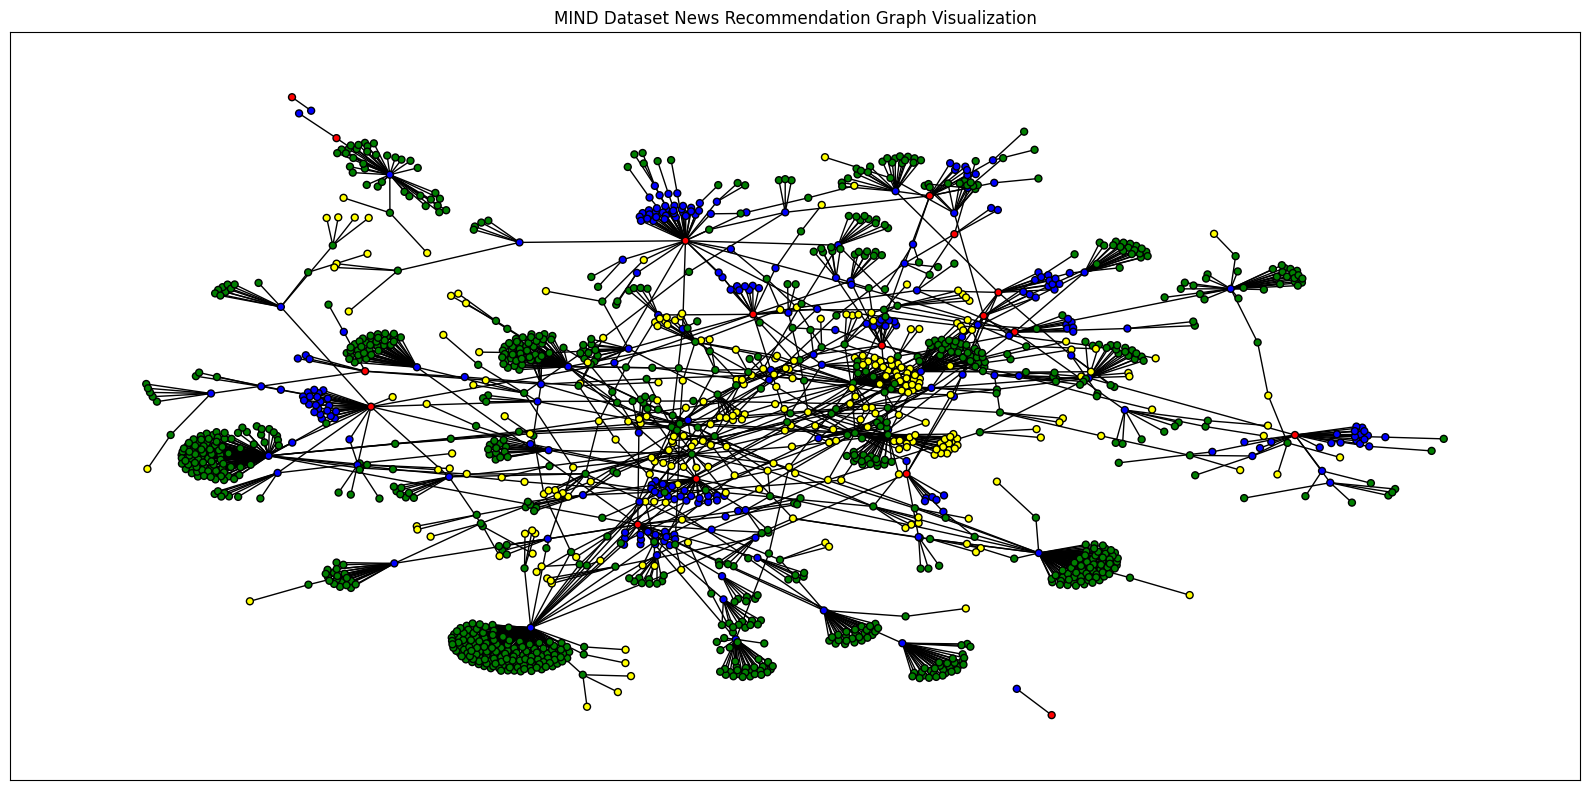

In [16]:
import matplotlib.pyplot as plt

color_map = {"news_category": 'red', "news_sub_category": 'blue', 'news_ids': 'green', 'user_ids': 'yellow'}
base_options = {"with_labels": False, "edgecolors": "black", "node_size": 25, 'font_size': 10}

plt.figure(figsize=(16, 8))
plt.title("MIND Dataset News Recommendation Graph Visualization")

nodes_to_plot = nodes_data_train[nodes_data_train['node_type'].isin(['news_category', 'news_sub_category'])]['node_id'].tolist()
nodes_to_plot += nodes_data_train[nodes_data_train['node_type'] == 'news_ids']['node_id'].sample(n=1000).tolist()
nodes_to_plot += nodes_data_train[nodes_data_train['node_type'] == 'user_ids']['node_id'].sample(n=1000).tolist()

sub_graph = G.subgraph(nodes_to_plot)
sub_graph = sub_graph.subgraph([node_id for node_id in sub_graph.nodes() if sub_graph.degree[node_id] > 0])

pos = nx.spring_layout(sub_graph, k=0.05)

node_colors = [color_map[node_attributes["node_type"]] for _, node_attributes in sub_graph.nodes(data=True)]

nx.draw_networkx(sub_graph, pos=pos, node_color=node_colors, **base_options)
plt.tight_layout()
plt.show()

#### Create Validation Data

In [17]:
impression_data = user_behaviour_data_train[['Impression ID', 'User ID', 'Impressions']].drop_duplicates()
impression_data['Impressions'] = impression_data['Impressions'].str.split(' ')

impression_data = impression_data.explode('Impressions').reset_index(drop=True)
impression_data[['Impressions', 'Clicked']] = impression_data['Impressions'].str.split('-', expand=True).rename(columns={0: 'Impressions', 1: 'Clicked'})

impression_data['source'] = impression_data['User ID'].map(user_id_mapping)
impression_data['destination'] = impression_data['Impressions'].map(news_id_mapping)

feature_embeddings = feature_embeddings.to('cpu')

In [18]:
from numpy.linalg import norm

def calculate_cosine_similarity(row) -> float:
    source, destination = row

    source_embeddings = feature_embeddings[source]
    destination_embeddings = feature_embeddings[destination]

    return np.dot(source_embeddings, destination_embeddings) / (norm(source_embeddings) * norm(destination_embeddings))

In [19]:
tqdm.pandas()

impression_data['Cosine Similarity'] = impression_data[['source', 'destination']].progress_apply(calculate_cosine_similarity, axis=1)
impression_data['Similarity Rank'] = (impression_data.groupby(['Impression ID', 'User ID'])["Cosine Similarity"]
                                      .rank(method='dense', ascending=False).astype(np.int64))

100%|██████████| 5843444/5843444 [02:29<00:00, 39049.25it/s]


In [20]:
impression_data

,Impression ID,User ID,Impressions,Clicked,source,destination,Cosine Similarity,Similarity Rank
0,1,U13740,N55689,1,53762,33899,0.297395,1
1,1,U13740,N35729,0,53762,50688,0.187525,2
2,2,U91836,N20678,0,99035,37404,0.132068,8
3,2,U91836,N39317,0,99035,41305,0.179459,4
4,2,U91836,N58114,0,99035,34906,0.077945,9
...,...,...,...,...,...,...,...,...
5843439,156964,U44625,N39317,0,71573,41305,0.257824,18
5843440,156965,U64800,N61233,0,83230,40780,-0.041921,4
5843441,156965,U64800,N33828,1,83230,34033,0.062673,3
5843442,156965,U64800,N19661,0,83230,48441,0.229194,1


#### Creating GNN Models

In [21]:
from torch_geometric.data import Data

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
data = Data(x=feature_embeddings.to(device).to(torch.float), edge_index=edge_index).to(device)

data

Data(x=[101561, 384], edge_index=[2, 982630])

In [22]:
from torch_geometric.nn import GATConv
import torch.nn as nn

class GAT(nn.Module):

    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GAT, self).__init__()

        self.conv1 = GATConv(in_channels, hidden_channels // 8, concat=True, heads=8)
        self.conv2 = GATConv(hidden_channels, hidden_channels // 8, concat=True, heads=8)
        self.conv3 = GATConv(hidden_channels, hidden_channels // 8, concat=True, heads=8)
        self.conv4 = GATConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = torch.relu(self.conv3(x, edge_index))

        return self.conv4(x, edge_index)

class LinkPredictor(nn.Module):

    def __init__(self, in_channels):
        super(LinkPredictor, self).__init__()

        self.lin = nn.Linear(in_channels, 1)

    def forward(self, z, edge_index):
        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]

        return torch.sigmoid((z_i * z_j).sum(dim=-1))

#### Training, Testing and Predicting Functions

In [23]:
from torch_geometric.utils import negative_sampling

def train(model_object, predictor_object, optimizer):
    model_object.train()
    predictor_object.train()
    optimizer.zero_grad()

    z = model_object(data.x, data.edge_index)
    pos_pred = predictor_object(z, data.edge_index)

    neg_edge_index = negative_sampling(
        edge_index=data.edge_index, num_nodes=data.num_nodes, num_neg_samples=data.edge_index.size(1))

    neg_pred = predictor_object(z, neg_edge_index)

    pos_loss = -torch.log(pos_pred + 1e-15).mean()
    neg_loss = -torch.log(1 - neg_pred + 1e-15).mean()

    loss = pos_loss + neg_loss

    loss.backward()
    optimizer.step()

    return loss.item()

In [24]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

@torch.no_grad()
def test(model_object, predictor_object):
    model_object.eval()
    predictor_object.eval()

    z = model_object(data.x, data.edge_index)

    pos_pred = predictor_object(z, data.edge_index)
    pos_labels = torch.ones(pos_pred.size(0))

    neg_edge_index = negative_sampling(
        edge_index=data.edge_index, num_nodes=data.num_nodes, num_neg_samples=data.edge_index.size(1))

    neg_pred = predictor_object(z, neg_edge_index)
    neg_labels = torch.zeros(neg_pred.size(0))

    y_pred = torch.cat([pos_pred, neg_pred], dim=0).to('cpu')
    y_true = torch.cat([pos_labels, neg_labels], dim=0)

    auc = roc_auc_score(y_true, y_pred)
    y_pred_class = (y_pred >= 0.5).float()
    accuracy = accuracy_score(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred_class)

    return auc, accuracy, f1

In [25]:
@torch.no_grad()
def predict_links(test_edges, model_object, predictor_object):
    model_object.eval()
    predictor_object.eval()

    z = model_object(data.x, data.edge_index)
    edge_index = torch.tensor(test_edges, dtype=torch.long).t().contiguous()

    link_probs = predictor_object(z, edge_index)
    link_predictions = (link_probs >= 0.5).long()

    return link_predictions, link_probs

#### Training and Testing Models

##### GAT Model

In [26]:
import torch.optim as optim

embedding_dim = 128

model_object = GAT(in_channels=data.num_features, hidden_channels=embedding_dim, out_channels=embedding_dim).to(device)
predictor_object = LinkPredictor(embedding_dim).to(device)

optimizer = optim.Adam(list(model_object.parameters()) + list(predictor_object.parameters()), lr=0.01)

In [27]:
for epoch in range(1, 101):
    loss = train(model_object=model_object, predictor_object=predictor_object, optimizer=optimizer)

    if epoch % 10 == 0:
        auc, accuracy, f1 = test(model_object=model_object, predictor_object=predictor_object)
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

Epoch 010, Loss: 1.3656, AUC: 0.5778, Accuracy: 0.5049, F1 Score: 0.6688
Epoch 020, Loss: 1.3015, AUC: 0.6756, Accuracy: 0.5882, F1 Score: 0.6391
Epoch 030, Loss: 1.2797, AUC: 0.6910, Accuracy: 0.6129, F1 Score: 0.6653
Epoch 040, Loss: 1.2530, AUC: 0.7176, Accuracy: 0.6230, F1 Score: 0.6763
Epoch 050, Loss: 1.2169, AUC: 0.7506, Accuracy: 0.6394, F1 Score: 0.6958
Epoch 060, Loss: 1.1831, AUC: 0.7840, Accuracy: 0.6561, F1 Score: 0.7104
Epoch 070, Loss: 1.1463, AUC: 0.8099, Accuracy: 0.6765, F1 Score: 0.7267
Epoch 080, Loss: 1.1210, AUC: 0.8305, Accuracy: 0.6930, F1 Score: 0.7428
Epoch 090, Loss: 1.0976, AUC: 0.8548, Accuracy: 0.7066, F1 Score: 0.7569
Epoch 100, Loss: 1.0850, AUC: 0.8601, Accuracy: 0.7108, F1 Score: 0.7589


In [28]:
validation_data_edges = list(zip(impression_data['source'], impression_data['destination']))

In [29]:
predictions, probabilities = predict_links(validation_data_edges, model_object=model_object, predictor_object=predictor_object)

validation_labels = impression_data['Clicked'].astype(np.int64)
y_pred_val = predictions.to('cpu')

In [30]:
print(f"Validation Accuracy: {accuracy_score(validation_labels, y_pred_val):.3f}")
print(f"Validation Precision: {precision_score(validation_labels, y_pred_val):.3f}")
print(f"Validation Recall: {recall_score(validation_labels, y_pred_val):.3f}")
print(f"Validation F1 Score: {f1_score(validation_labels, y_pred_val):.3f}")

Validation Accuracy: 0.461
Validation Precision: 0.046
Validation Recall: 0.620
Validation F1 Score: 0.085


#### Ranking System

In [31]:
impression_data['Probability'] = probabilities.to('cpu')
impression_data['Probability Rank'] = (impression_data.groupby(['Impression ID', 'User ID'])["Probability"]
                                       .rank(method='dense', ascending=False).astype(np.int64))

In [32]:
impression_data

,Impression ID,User ID,Impressions,Clicked,source,destination,Cosine Similarity,Similarity Rank,Probability,Probability Rank
0,1,U13740,N55689,1,53762,33899,0.297395,1,0.779414,1
1,1,U13740,N35729,0,53762,50688,0.187525,2,0.410522,2
2,2,U91836,N20678,0,99035,37404,0.132068,8,0.577198,3
3,2,U91836,N39317,0,99035,41305,0.179459,4,0.495677,8
4,2,U91836,N58114,0,99035,34906,0.077945,9,0.526836,7
...,...,...,...,...,...,...,...,...,...,...
5843439,156964,U44625,N39317,0,71573,41305,0.257824,18,0.480459,79
5843440,156965,U64800,N61233,0,83230,40780,-0.041921,4,0.089563,4
5843441,156965,U64800,N33828,1,83230,34033,0.062673,3,0.985418,1
5843442,156965,U64800,N19661,0,83230,48441,0.229194,1,0.218108,2


In [33]:
true_ranking = impression_data[['Impression ID', 'User ID', 'Similarity Rank']]
true_ranking = true_ranking.groupby(['Impression ID', 'User ID']).agg(list).reset_index().drop(columns=['User ID'])

true_ranking

,Impression ID,Similarity Rank
0,1,"[1, 2]"
1,2,"[8, 4, 9, 1, 6, 11, 7, 10, 2, 5, 3]"
2,3,"[3, 26, 16, 23, 33, 10, 15, 24, 25, 8, 9, 18, ..."
3,4,"[2, 1, 4, 3]"
4,5,"[61, 63, 18, 33, 52, 2, 32, 17, 22, 8, 48, 14,..."
...,...,...
156960,156961,"[28, 16, 24, 14, 26, 3, 2, 25, 30, 12, 6, 31, ..."
156961,156962,"[1, 29, 88, 79, 87, 59, 26, 43, 32, 44, 84, 3,..."
156962,156963,"[1, 33, 12, 14, 17, 32, 25, 2, 10, 19, 21, 6, ..."
156963,156964,"[119, 2, 40, 69, 50, 72, 34, 9, 29, 43, 37, 10..."


In [34]:
with open('../results/true_rank_gat.txt', 'w') as file:
    for impression_id, true_rank in tqdm(true_ranking.values.tolist()):
        rank_string = '[' + ','.join([str(rank) for rank in true_rank]) + ']'

        file.write(' '.join([str(impression_id), rank_string])+ '\n')

100%|██████████| 156965/156965 [00:00<00:00, 195905.47it/s]


In [35]:
final_prediction = impression_data[['Impression ID', 'User ID', 'Probability Rank']]
final_prediction = final_prediction.groupby(['Impression ID', 'User ID']).agg(list).reset_index().drop(columns=['User ID'])

final_prediction

,Impression ID,Probability Rank
0,1,"[1, 2]"
1,2,"[3, 8, 7, 4, 5, 6, 2, 9, 1, 11, 10]"
2,3,"[22, 21, 7, 30, 11, 18, 3, 2, 8, 9, 1, 31, 6, ..."
3,4,"[2, 1, 4, 3]"
4,5,"[5, 56, 52, 2, 16, 68, 64, 13, 3, 22, 20, 8, 4..."
...,...,...
156960,156961,"[24, 12, 21, 10, 20, 1, 7, 16, 27, 4, 14, 23, ..."
156961,156962,"[1, 31, 67, 7, 57, 87, 74, 89, 61, 64, 76, 50,..."
156962,156963,"[27, 36, 35, 2, 15, 10, 29, 3, 12, 28, 7, 13, ..."
156963,156964,"[68, 29, 59, 52, 108, 45, 80, 42, 23, 99, 40, ..."


In [36]:
with open('../results/prediction_gat.txt', 'w') as file:
    for impression_id, prediction_rank in tqdm(final_prediction.values.tolist()):
        rank_string = '[' + ','.join([str(rank) for rank in prediction_rank]) + ']'

        file.write(' '.join([str(impression_id), rank_string])+ '\n')

100%|██████████| 156965/156965 [00:00<00:00, 200404.53it/s]


In [37]:
def dcg_at_k(relevance_scores, k):
    relevance_scores = np.array(relevance_scores)[:k]
    discounts = np.log2(np.arange(2, len(relevance_scores) + 2))

    return np.sum(relevance_scores / discounts)

def ndcg_at_k(ground_truth, predictions, k):
    relevance_scores = [len(ground_truth) - ground_truth.index(item) if item in ground_truth else 0 for item in predictions]
    dcg = dcg_at_k(relevance_scores, k)

    ideal_relevance_scores = sorted(relevance_scores, reverse=True)
    idcg = dcg_at_k(ideal_relevance_scores, k)

    return dcg / idcg if idcg > 0 else 0.0

def calculate_ndcg_for_files(ground_truth_ranks, predicted_ranks, ks=[5, 10, 15]):
    ndcg_scores = {k: [] for k in ks}

    for query_id, ground_truth in ground_truth_ranks.items():
        if query_id in predicted_ranks:
            predictions = predicted_ranks[query_id]
            for k in ks:
                ndcg_scores[k].append(ndcg_at_k(ground_truth, predictions, k))

    averaged_ndcg_scores = {k: np.mean(ndcg_scores[k]) for k in ks}

    return averaged_ndcg_scores

def mrr_at_k(ground_truth, predictions, k):
    for rank, item in enumerate(predictions[:k], start=1):
        if item in ground_truth:
            return 1.0 / rank

    return 0.0

def calculate_mrr_for_files(ground_truth_ranks, predicted_ranks, ks=[5, 10, 15]):
    mrr_scores = {k: [] for k in ks}

    for query_id, ground_truth in ground_truth_ranks.items():
        if query_id in predicted_ranks:
            predictions = predicted_ranks[query_id]
            for k in ks:
                mrr_scores[k].append(mrr_at_k(ground_truth, predictions, k))

    averaged_mrr_scores = {k: np.mean(mrr_scores[k]) for k in ks}
    return averaged_mrr_scores

In [38]:
import json

def create_mapping_dict(lines: list) -> dict:
    lines = list(map(lambda x: x.strip('\n').split(), lines))
    lines = list(map(lambda x: (x[0], json.loads(x[1])), lines))

    return {impression_id: ranks for impression_id, ranks in lines}

In [39]:
true_ranking_file = create_mapping_dict(open('../results/true_rank_gat.txt', 'r').readlines())
predicted_ranking_file_gcn = create_mapping_dict(open('../results/prediction_gat.txt', 'r').readlines())

In [40]:
(calculate_ndcg_for_files(true_ranking_file, predicted_ranking_file_gcn),
 calculate_mrr_for_files(true_ranking_file, predicted_ranking_file_gcn))

({5: 0.6284801153515256, 10: 0.6753729566702209, 15: 0.7078243886069483},
 {5: 1.0, 10: 1.0, 15: 1.0})